Column definitions (from project challenge description)

    DATOP - Date of flight
    FLTID - Flight number
    DEPSTN - Departure point
    ARRSTN - Arrival point
    STD - Scheduled Time departure
    STA - Scheduled Time arrival
    STATUS - Flight status
    ETD - Expected Time departure
    ETA - Expected Time arrival
    ATD - Actual Time of Departure
    ATA - Actual Time of arrival
    DELAY1 - Delay code 1
    DUR1 - delay time 1
    DELAY2 - Delay code 2
    DUR2 - delay time 2
    DELAY3 - Delay code 3
    DUR3 - delay time 3
    DELAY4 - Delay code 4
    DUR4 - delay time 4
    AC - Aircraft Code


In [1]:
#import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import pickle

#import supporting functions used for cleaning
from supporting_functions import prediction_plot

In [2]:
# load data (cleaned with preprocess_data.ipynb)
with open('data/clean_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

X_train            = loaded_data[0]
X_test             = loaded_data[1]
y_train            = loaded_data[2]
y_test             = loaded_data[3]
discarded_features = loaded_data[4]
scaler             = loaded_data[5]

## filter the delayed flights / sub-sample data

In [3]:
delayed_flights_train = y_train > 0
X_train = X_train[delayed_flights_train]
y_train = y_train[delayed_flights_train]

delayed_flights_test = y_test > 0
X_test = X_test[delayed_flights_test]
y_test = y_test[delayed_flights_test]

## Calculate and evaluate very simplistic (baseline) model that just predicts a constant (the average) for all delays

Train Mean Squared Error: 19105.041598154316
test Mean Squared Error: 19697.74695476427


Text(0.5, 1.0, 'Test Set (MSE: 19697.75)')

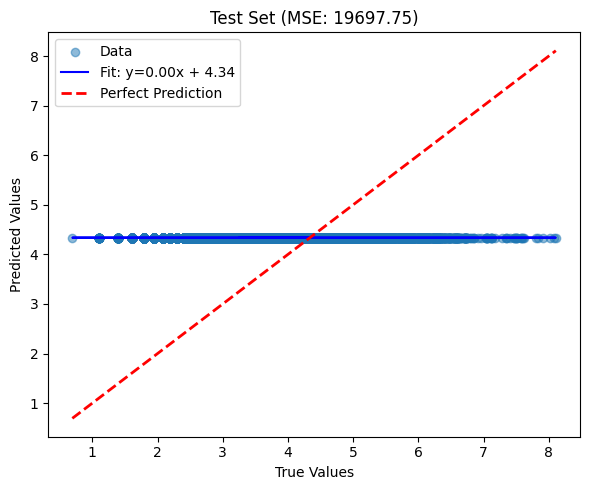

In [4]:
y_pred_train = np.zeros(np.shape(y_train)) + np.log1p(np.mean(np.expm1(y_train)))
y_pred       = np.zeros(np.shape(y_test))  + np.log1p(np.mean(np.expm1(y_train)))

train_mse = mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))
test_mse  = mean_squared_error(np.expm1(y_test),  np.expm1(y_pred))

print("Train Mean Squared Error:", train_mse)
print("test Mean Squared Error:",  test_mse)

prediction_plot(y_test,y_pred)
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
plt.title(f'Test Set (MSE: {test_mse:.2f})')

## Fit and evaluate regression model to the delayed flights only

In [5]:
from sklearn.metrics import make_scorer, fbeta_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold

estimator = XGBRegressor(    
    seed=1234,
    enable_categorical=True
)

parameters = {
    'n_estimators':     range(150, 250, 50),
    'max_depth':        range(2, 10, 2),
    'learning_rate':    [.1, .2, .3, .4],
    'colsample_bytree': [.7, .8, .9, 1]
}

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1234)
#cv = 2

#scorer = make_scorer(fbeta_score,beta=1) #lower beta puts more emphasis on recall
scorer = 'neg_mean_absolute_error'

Grid_search  = GridSearchCV(
                            estimator=estimator,
                            param_grid=parameters,
                            scoring = scorer,
                            n_jobs = -1,
                            cv = cv,
                            verbose=True
                            )

# execute Random search
Grid_search.fit(X_train, y_train)

#make predictions using the trained model
y_pred_train = Grid_search.predict(X_train)
y_pred       = Grid_search.predict(X_test)

best_model = Grid_search.best_estimator_

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


In [6]:
import pickle

# save model to file so we don't have to run it again
with open('models/xgboost_regression.pkl','wb') as f:
    pickle.dump(Grid_search,f)  

In [7]:
Grid_search.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 150}

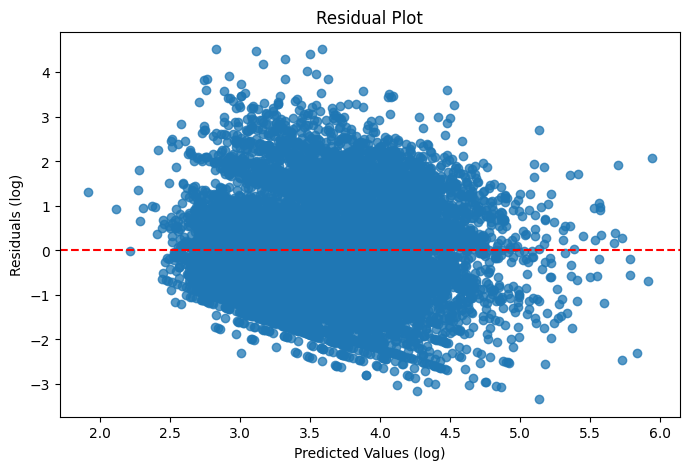

In [8]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.75)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values (log)')
plt.ylabel('Residuals (log)')
plt.title('Residual Plot')
plt.show()

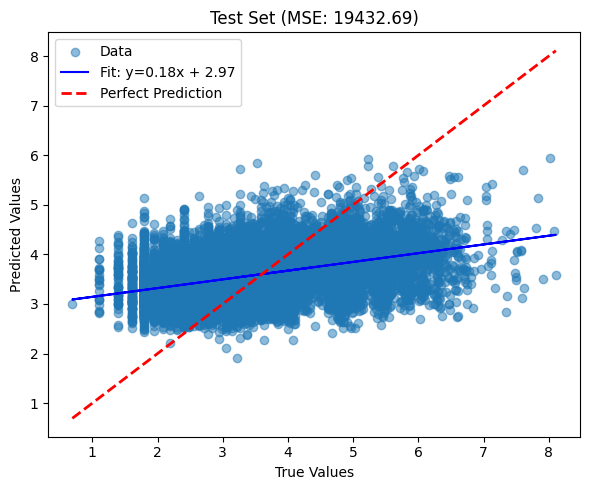

In [9]:
prediction_plot(y_test,y_pred)
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
plt.title(f'Test Set (MSE: {mse:.2f})')
plt.savefig('./plots/Regressor_test_MSE.png', bbox_inches='tight',transparent=True)
